<a href="https://colab.research.google.com/github/smnststn/Fruits_vegetables/blob/main/Refined_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library imports

In [101]:
import os  # Operating system utilities
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import cv2  # Computer vision tasks

# Image processing
from PIL import Image  # Image handling
import matplotlib.pyplot as plt  # Plotting utilities

# Kaggle utilities
import kagglehub  # Kaggle API utilities

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Machine Learning - Data preprocessing
from sklearn.model_selection import train_test_split  # Splitting data into training and testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation

# Machine Learning - Model utilities
from keras.utils import to_categorical  # Label encoding for classification
from keras.callbacks import EarlyStopping, ModelCheckpoint  # Model training utilities

# Deep Learning - Model architecture
from tensorflow.keras.models import Sequential  # Sequential model building
from tensorflow.keras.layers import (  # Deep learning layers
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)

# Pretrained models
from keras.applications import MobileNetV3Large  # Pretrained MobileNet model
from keras.layers import GlobalAveragePooling2D  # Global Average Pooling for feature extraction
from keras.models import Model  # Base model for custom architectures

# PyTorch - Deep learning framework
import torch  # Core PyTorch module
import torch.nn as nn  # Neural network utilities
import torchvision  # Computer vision models and datasets
import torchvision.transforms as transforms  # Image transformations for PyTorch

# Functions

In [102]:
def compute_heatmap(model,img):
  """
  Computes the heatmap for the given image.
  """

  model.eval()
  # Compute logits from the model
  logits = model(img)
  # Model's prediction
  pred = logits.max(-1)[-1]
  # Activations from the model
  activations = image_to_heatmaps(img)
  # Compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # Average gradients of the featuremap
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # Multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # Calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()

  return heatmap, pred

In [103]:
def upsampleHeatmap(map, image):
  """
  Upsamples the heatmap to the size of the input image.
  """

  # Permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # Maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # Normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # Resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # Change this to balance between heatmap and image
  map = np.uint8(map*0.7 + image*0.3)

  return map

In [104]:
def display_images(upsampled_map, image):
  """
  Displays the upsampled heatmap and the original image.
  """

  image = image.squeeze(0).permute(1, 2, 0)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].imshow(upsampled_map)
  axes[0].set_title("Heatmap")
  axes[0].axis('off')
  axes[1].imshow(image)
  axes[1].set_title("Original Image")
  axes[1].axis('off')

  plt.show()

In [105]:
def plot_history(history):
  """
  Visualizes model's loss and accuracy over time.
  """

  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'], color='orange',linewidth=3.0)
  plt.plot(history.history['val_loss'],color='blue',linewidth=3.0)

  min_val_loss = min(history.history['val_loss'])
  min_val_loss_idx = np.argmin(history.history['val_loss'])
  plt.axhline(min_val_loss, color='red', linestyle='dashed')
  plt.plot(
        min_val_loss_idx,
        min_val_loss,
        'ro',
        label=f'epoch: {min_val_loss_idx}'
  )

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], color='orange', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], color='blue',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

  plt.show()

In [106]:
def plot_incorrect_predictions(incorrect_predictions, images, grid_cols=4, figsize_factor=4):
  """
  Plots a grid of misclassified images along with their true and predicted labels.

  Parameters:
  - incorrect_predictions (pd.DataFrame): DataFrame containing incorrect predictions with columns:
      ['index', 'true_label_name', 'predicted_label_name']
  - images (array-like): Array or list containing the images.
  - grid_cols (int, optional): Number of columns in the grid (default: 4).
  - figsize_factor (int, optional): Factor to determine figure size scaling (default: 4).
  """

  # Calculate grid dimensions
  num_images = len(incorrect_predictions)
  grid_rows = int(np.ceil(num_images / grid_cols))

  # Create the grid of subplots
  fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * figsize_factor, grid_rows * figsize_factor))

  # Flatten axes array for easy iteration
  axes = axes.flatten()

  # Loop through images and plot on grid
  for i, index in enumerate(incorrect_predictions['index']):
      # Display the image on the subplot
      axes[i].imshow(images[index])

      # Set the title of the subplot
      title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
      axes[i].set_title(title)

      # Remove ticks and labels from the subplot
      axes[i].set_xticks([])
      axes[i].set_yticks([])

  # Hide any unused subplots
  for j in range(num_images, grid_cols * grid_rows):
      axes[j].axis('off')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()

In [107]:
def crop_to_square(image):
    """
    Crops an image to a square ratio.
    """
    width, height = image.size

    # Determine the cropping box dimensions
    crop_size = min(width, height)  # Use the smaller dimension for the square
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

In [108]:
def load_images(path, encoding, image_width = 224, image_height = 224, crop = False, report = False):
  """
  Loads images from a directory and labels them based on the folder structure.

  Parameters:
  - path: directory of images, Encoding = dictionary of categories
  - image_width: width of the resized images (default: 224)
  - image_height: height of the resized images (default: 224)
  - crop: enables function crop_to_square
  - report: warns if actual size is smaller than requested

  Function returns  X=images, y=labels
  """

  X = []
  y = []

  # Loop for each category (fruit/vegetable)
  for index, category_name in encoding.items(): # (folder_path)[0:7] --> only first 7 categories / to be removed

    category_path = os.path.join(path, category_name)
    if os.path.exists(category_path):
      image_list = []

      # Loop for each file
      for filename in os.listdir(category_path):

        # Including all formats
        if filename.endswith((".jpg",".png",".jpeg")):
          img_path = os.path.join(category_path, filename)
          img = Image.open(img_path)

          # Get size/ration of image for below reporting
          width, height = img.size
          aspect_ratio = width / height

          if report:
            # Check if actual size is smaller than requested
            if width < image_width or height < image_height:
              print(f"{filename} in category {category_name} has smaller size than requested.")
              print(f"Actual size: {width} x {height} < Requested size:{image_width} x {image_height} \n")

          # Crops image to square
          if crop:
            img = crop_to_square(img)

          # Convert to RGB
          img.convert('RGB')

          # Resizes to requested width/height (default 224x224)
          img_resized = img.resize((image_width, image_height))
          img_array = np.array(img_resized)

          if img_array.ndim == 2:  # If grayscale, convert to RGB
              img_array = np.stack((img_array,) * 3, axis=-1) # Convert to 3 channels if needed
              # Check if the image has 4 channels (RGBA) and convert if necessary
          elif img_array.shape[2] == 4:  # If RGBA, convert to RGB
              img_array = img_array[:,:,:3] # Removing the alpha channel by selecting only the first 3 (RGB) channels.
          image_list.append(img_array)

      X += image_list
      y += [index] * len(image_list)

  return X, y

# Loading data

In [109]:
# Download latest version
# path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

In [ ]:
path = 'C:/Users/smnst/Fruits_vegetables/data/'
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

In [ ]:
# Do we want to load additional dataset?
additional = True

In [ ]:
if additional:
    additional_train_dir = os.path.join(path, 'train_addition')

# Pre-processing

## Numerical encoding for each category

In [111]:
# Prepatation of encoding in alphatelical order
dir_list = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
dir_list.sort()

In [112]:
categories = {i: name for i, name in enumerate(dir_list)}
categories

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

## Storing data in variables

In [ ]:
X_test, y_test = load_images(test_dir, categories, crop=False)
X_train, y_train = load_images(train_dir, categories, crop=False)

if additional:
    X_additional, y_additional = load_images(additional_train_dir, categories, crop=False)
    print(f"additional {len(X_additional)} + train {len(X_train)}")

c:\Users\smnst\Fruits_vegetables\.venv\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
if additional:
    # Extends training data with additional set
    X_train = np.concatenate([X_train, X_additional])
    y_train = np.concatenate([y_train, y_additional])
    print(f"additional + train = {len(X_train)}")

'# Extends training data with additional set\nX_train = np.concatenate([X_train, X_additional])\ny_train = np.concatenate([y_train, y_additional])'

In [120]:
# Convert training and testing image data into tensors
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Convert labels to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [121]:
# Store unscaled training and testing data without scaling for Mobilnetv3
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()

In [122]:
# Scale data (images) for our model
X_train = X_train / 255
X_test = X_test / 255

In [123]:
# One hot encoding on labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [124]:
early = EarlyStopping(
    # Monitor accuracy on validation data
    monitor="val_accuracy",
    # Stop if there is no improvement of at least 0.3%
    min_delta=0.003,
    # Within the last 10 epochs
    patience=10,
    # If stopping, restore weights from the epoch with the highest validation accuracy
    restore_best_weights=True,
)

save = ModelCheckpoint(
    # Filepath to save the model
    filepath="best_model.keras",
    # Monitor accuracy on validation data
    monitor="val_accuracy",
    # Save only the best model based on the monitored metric
    save_best_only=True,
    # Save both the model architecture and weights in a single file
    save_weights_only=False,
    # Save after every epoch
    save_freq="epoch"
)

In [125]:
# Create a custom model - inspired by the VGG16 architecture
model = Sequential()

# Input layer must match the shape of X
model.add(Input(shape=X_train.shape[1:]))

# Convolutional block with pooling
model.add(Conv2D(16, (3, 3)))  # First convolutional layer
model.add(MaxPooling2D())  # First pooling layer
model.add(Conv2D(32, (3, 3)))  # Second convolutional layer
model.add(MaxPooling2D())  # Second pooling layer

# Flatten the feature maps into a vector
model.add(Flatten())

# Regularization to prevent overfitting (missing dropout or L2 regularization here)

# Output layer -> Multi-class single-label classification -> Softmax activation
model.add(Dense(36, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 36)             │     3,359,268 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,364,356 (12.83 MB)

 Trainable params: 3,364,356 (12.83 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.1053 - loss: 10.2456 - val_accuracy: 0.4249 - val_loss: 2.2084
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.4701 - loss: 1.9819 - val_accuracy: 0.8924 - val_loss: 0.5430
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8144 - loss: 0.7750 - val_accuracy: 0.9263 - val_loss: 0.3511
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.9409 - loss: 0.2759 - val_accuracy: 0.9632 - val_loss: 0.3126
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.9741 - loss: 0.1338 - val_accuracy: 0.9660 - val_loss: 0.2771
Epoch 6/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9873 - loss: 0.0765 - val_accuracy: 0.9575 - val_loss: 0.3201
Epoch 7/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.9859 - loss: 0.1080 - val_accuracy: 0.9518 - val_loss: 0.3808
Epoch 8/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.9899 - loss: 

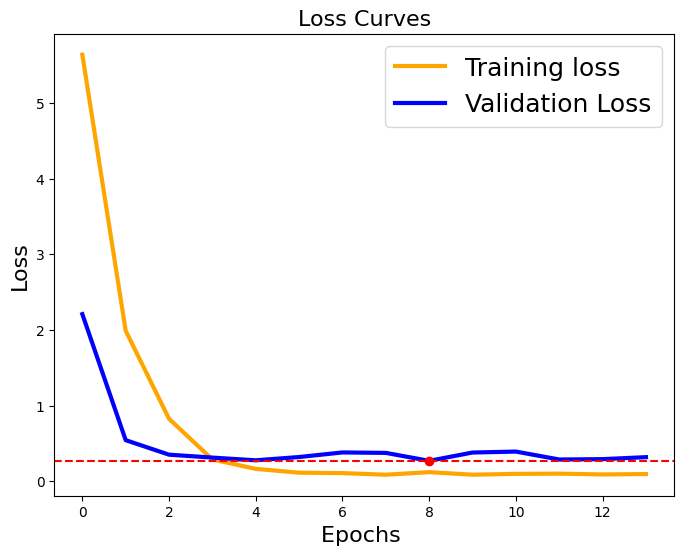

In [127]:
plot_history(history)

In [128]:
X_train.shape

(3040, 224, 224, 3)

In [129]:
# Predikce na testovacích datech
y_pred = model.predict(X_test)

# Převést predikce na labely (indexy kategorií)
y_pred = np.argmax(y_pred, axis=1)

# Převést one-hot encoded y_test na labely (indexy kategorií)
y_test_labels = np.argmax(y_test, axis=1)

# Tisk classification reportu
print(classification_report(y_test_labels, y_pred, target_names=np.array(list(categories.values()))))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
               precision    recall  f1-score   support

        apple       1.00      0.78      0.88         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.89      0.89      0.89         9
       carrot       1.00      0.89      0.94         9
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.91      1.00      0.95        10
         kiwi       1.00

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
               precision    recall  f1-score   support

        apple       1.00      0.78      0.88         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.89      0.89      0.89         9
       carrot       1.00      0.89      0.94         9
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.91      1.00      0.95        10
         kiwi       1.00

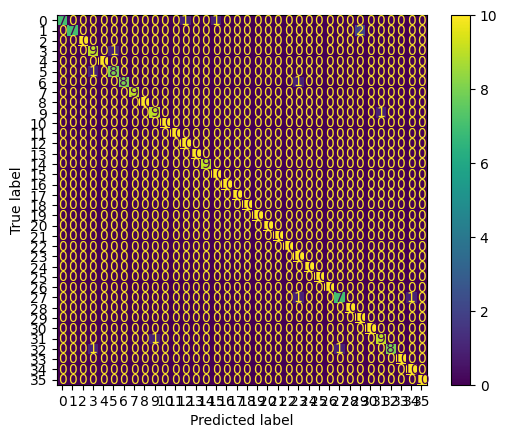

In [130]:
# Predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions to labels (category indices)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to labels (category indices)
y_test_labels = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=np.array(list(categories.values()))))

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [131]:
# Redefine class labels from the encoding dictionary
class_labels = list(categories.values())

# Get the true labels and predicted labels
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
pred_labels = model.predict(X_test)
pred_labels = np.argmax(pred_labels, axis=1) # Convert predictions to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [132]:
# Create a DataFrame for incorrect predictions
incorrect_predictions = pd.DataFrame({'index': np.where(true_labels != pred_labels)[0],
                                       'true_label': true_labels[np.where(true_labels != pred_labels)[0]],
                                       'predicted_label': pred_labels[np.where(true_labels != pred_labels)[0]]})

# Map label indices to label names using the encoding
incorrect_predictions['true_label_name'] = incorrect_predictions['true_label'].map(categories)
incorrect_predictions['predicted_label_name'] = incorrect_predictions['predicted_label'].map(categories)

# Print the DataFrame
incorrect_predictions

index  true_label  predicted_label true_label_name predicted_label_name
0       4           0               12           apple               garlic
1       8           0               15           apple             jalepeno
2      11           1               29          banana            soy beans
3      17           1               29          banana            soy beans
4      35           3                5     bell pepper             capsicum
5      52           5                3        capsicum          bell pepper
6      61           6               23          carrot                 pear
7      85           9               31            corn            sweetcorn
8     266          27               23          potato                 pear
9     271          27               34          potato               turnip
10    308          31                9       sweetcorn                 corn
11    316          32               27     sweetpotato               potato
12    320          32                3     sweetpotato          bell pepper

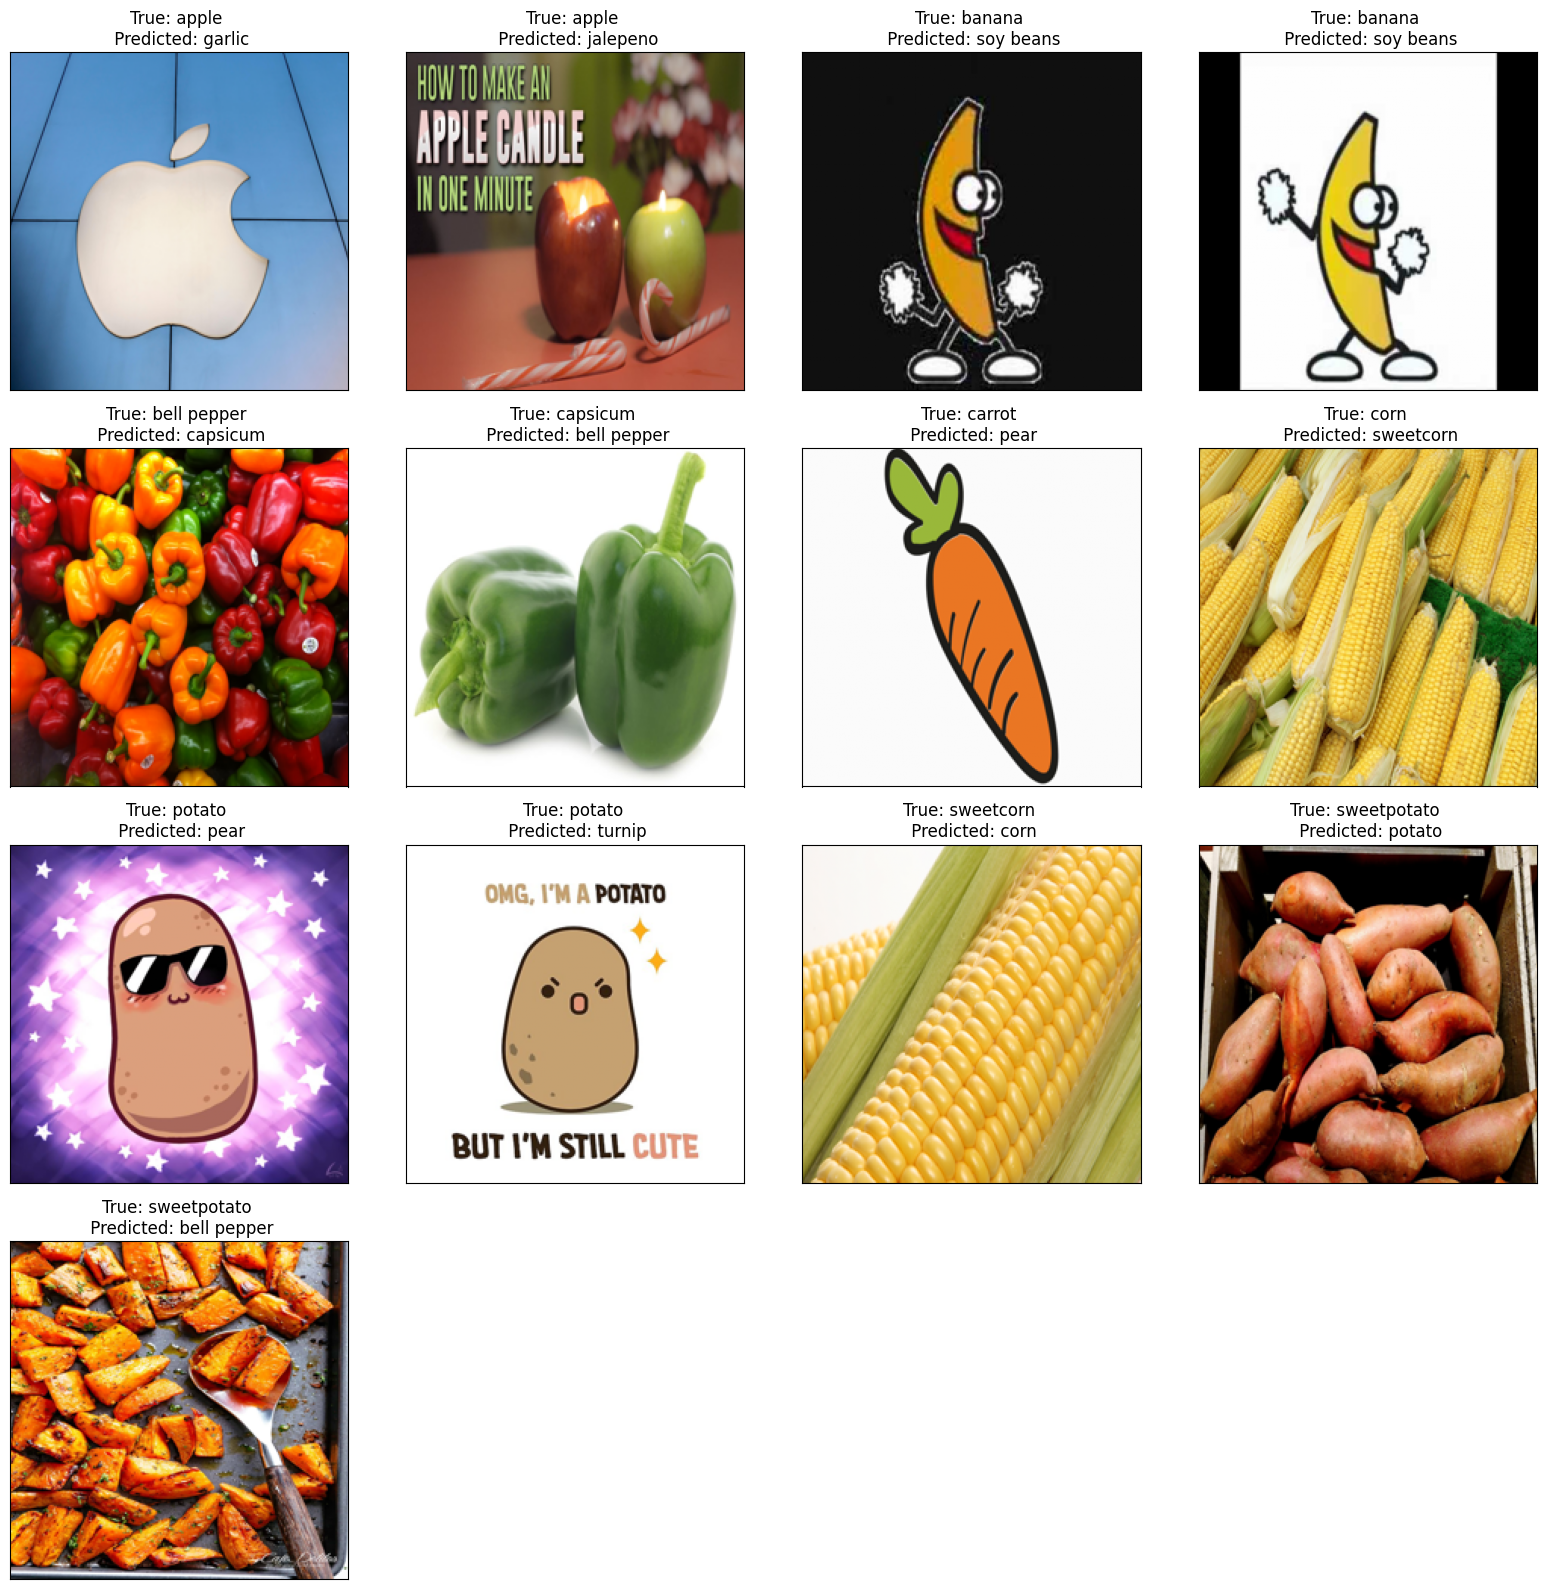

In [133]:
plot_incorrect_predictions(incorrect_predictions, X_test)

In [134]:
# Load pre-trained model
vgg_model = torchvision.models.vgg16(pretrained=True)

# transformation for passing image into the network
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(vgg_model.features[:-4]))

c:\Users\smnst\Fruits_vegetables\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\smnst\Fruits_vegetables\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [135]:
'''# Activation map for incorrect predictions

for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    example = X_test_not_scaled[index].unsqueeze(0)
    heatmap,pred = compute_heatmap(vgg_model,example)
    upsampled_map = upsampleHeatmap(heatmap, example)
    display_images(upsampled_map, example)'''

"# Activation map for incorrect predictions\n\nfor i, index in enumerate(incorrect_predictions['index']):\n    # Display the image on the subplot\n    example = X_test_not_scaled[index].unsqueeze(0)\n    heatmap,pred = compute_heatmap(vgg_model,example)\n    upsampled_map = upsampleHeatmap(heatmap, example)\n    display_images(upsampled_map, example)"

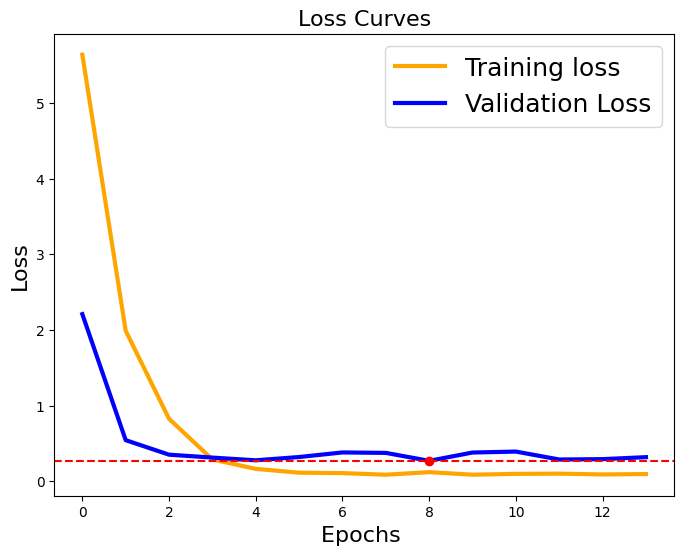

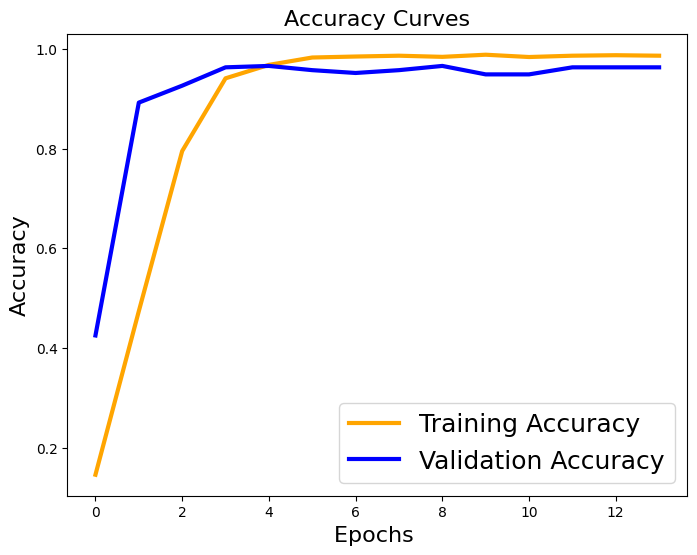

In [136]:
plot_history(history)

In [137]:
# načtení konvoluční featur extraction části MobilnetV3
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

In [138]:
# první MobilnetV3 konvoluční část
x = base_model.output
# převod na vektor s redukcí dat pomocí poolingu
x = GlobalAveragePooling2D()(x)
# stejná klasifikační vrstva jako u vlastní neuronky
# regularizace
x = Dropout(0.2)(x)
# softmax vrstva podle úlohy
x = Dense(36, activation="gelu")(x)

predictions = Dense(36, activation="softmax")(x)

# spojíme do kupy
model = Model(inputs=base_model.input, outputs=predictions)

# nepřetrénovávat MobilnetV3 vrstvy -> učíme pouze klasifikátor
for layer in base_model.layers:
    layer.trainable = False

# kompilace stejná jako u vlastní neuronky
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,032,280 (11.57 MB)

 Trainable params: 35,928 (140.34 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [139]:
history = model.fit(X_train_not_scaled, y_train, epochs=1000, validation_data=(X_test_not_scaled, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 624ms/step - accuracy: 0.2213 - loss: 3.0311 - val_accuracy: 0.8017 - val_loss: 0.9115
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 558ms/step - accuracy: 0.7167 - loss: 1.1093 - val_accuracy: 0.8697 - val_loss: 0.4717
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 54s 569ms/step - accuracy: 0.7974 - loss: 0.7242 - val_accuracy: 0.9093 - val_loss: 0.3596
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 534ms/step - accuracy: 0.8318 - loss: 0.5402 - val_accuracy: 0.9065 - val_loss: 0.3006
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 543ms/step - accuracy: 0.8623 - loss: 0.4447 - val_accuracy: 0.9405 - val_loss: 0.2439
Epoch 6/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 668ms/step - accuracy: 0.8847 - loss: 0.3660 - val_accuracy: 0.9263 - val_loss: 0.2200
Epoch 7/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 849ms/step - accuracy: 0.9010 - loss: 0.3137 - val_accuracy: 0.9433 - val_loss: 0.1983
Epoch 8/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 699ms/step - accuracy: 0.9092 - loss: 0

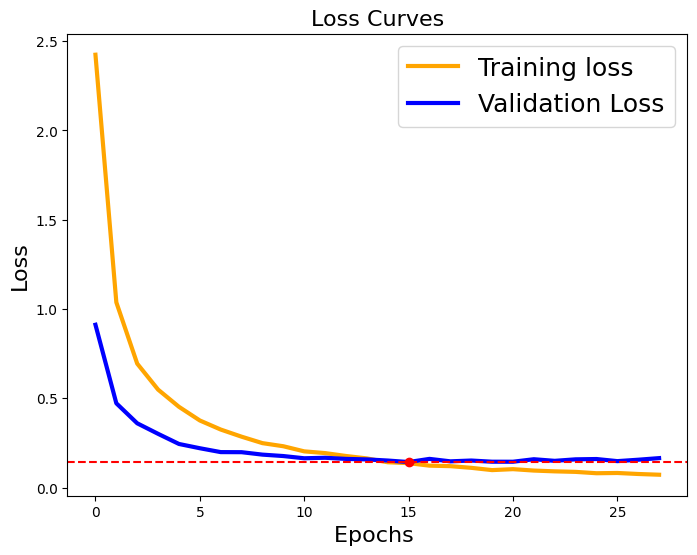

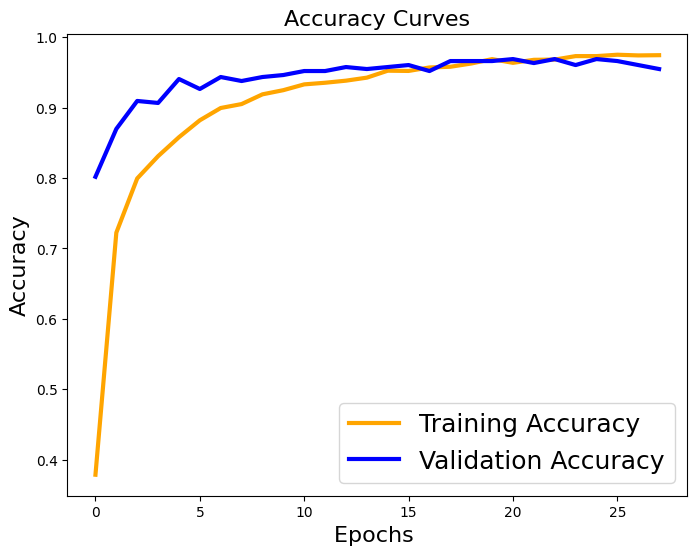

In [146]:
plot_history(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
               precision    recall  f1-score   support

        apple       0.75      0.67      0.71         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.90      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      1.00      0.95         9
       carrot       1.00      0.89      0.94         9
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00 

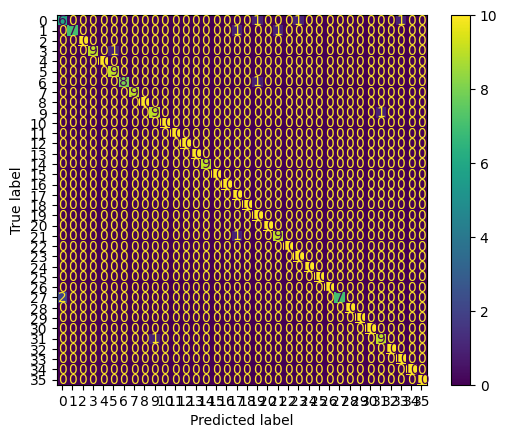

In [147]:
# Predikce na testovacích datech
y_pred = model.predict(X_test_not_scaled)

# Převést predikce na labely (indexy kategorií)
y_pred_labels = np.argmax(y_pred, axis=1)

# Převést one-hot encoded y_test na labely (indexy kategorií)
y_val_labels = np.argmax(y_test, axis=1)

# Tisk classification reportu
print(classification_report(y_val_labels, y_pred_labels, target_names=np.array(list(categories.values()))))

cm = confusion_matrix(y_val_labels, y_pred_labels) # Changed line
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [148]:
# Redefine class labels from the encoding dictionary
class_labels = list(categories.values())

# Assuming you already loaded your test data into X_test_not_scaled and y_test
# Get the true labels and predicted labels
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
pred_labels = model.predict(X_test_not_scaled)
pred_labels = np.argmax(pred_labels, axis=1) # Convert predictions to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 628ms/step


In [149]:
# Create a DataFrame for incorrect predictions
incorrect_predictions = pd.DataFrame({'index': np.where(true_labels != pred_labels)[0],
                                       'true_label': true_labels[np.where(true_labels != pred_labels)[0]],
                                       'predicted_label': pred_labels[np.where(true_labels != pred_labels)[0]]})

# Map label indices to label names using the encoding
incorrect_predictions['true_label_name'] = incorrect_predictions['true_label'].map(categories)
incorrect_predictions['predicted_label_name'] = incorrect_predictions['predicted_label'].map(categories)

# Print the DataFrame
incorrect_predictions

index  true_label  predicted_label true_label_name predicted_label_name
0       4           0               23           apple                 pear
1       5           0               19           apple                mango
2       8           0               33           apple               tomato
3      11           1               21          banana               orange
4      17           1               17          banana                lemon
5      35           3                5     bell pepper             capsicum
6      61           6               19          carrot                mango
7      88           9               31            corn            sweetcorn
8     213          21               17          orange                lemon
9     266          27                0          potato                apple
10    271          27                0          potato                apple
11    312          31                9       sweetcorn                 corn

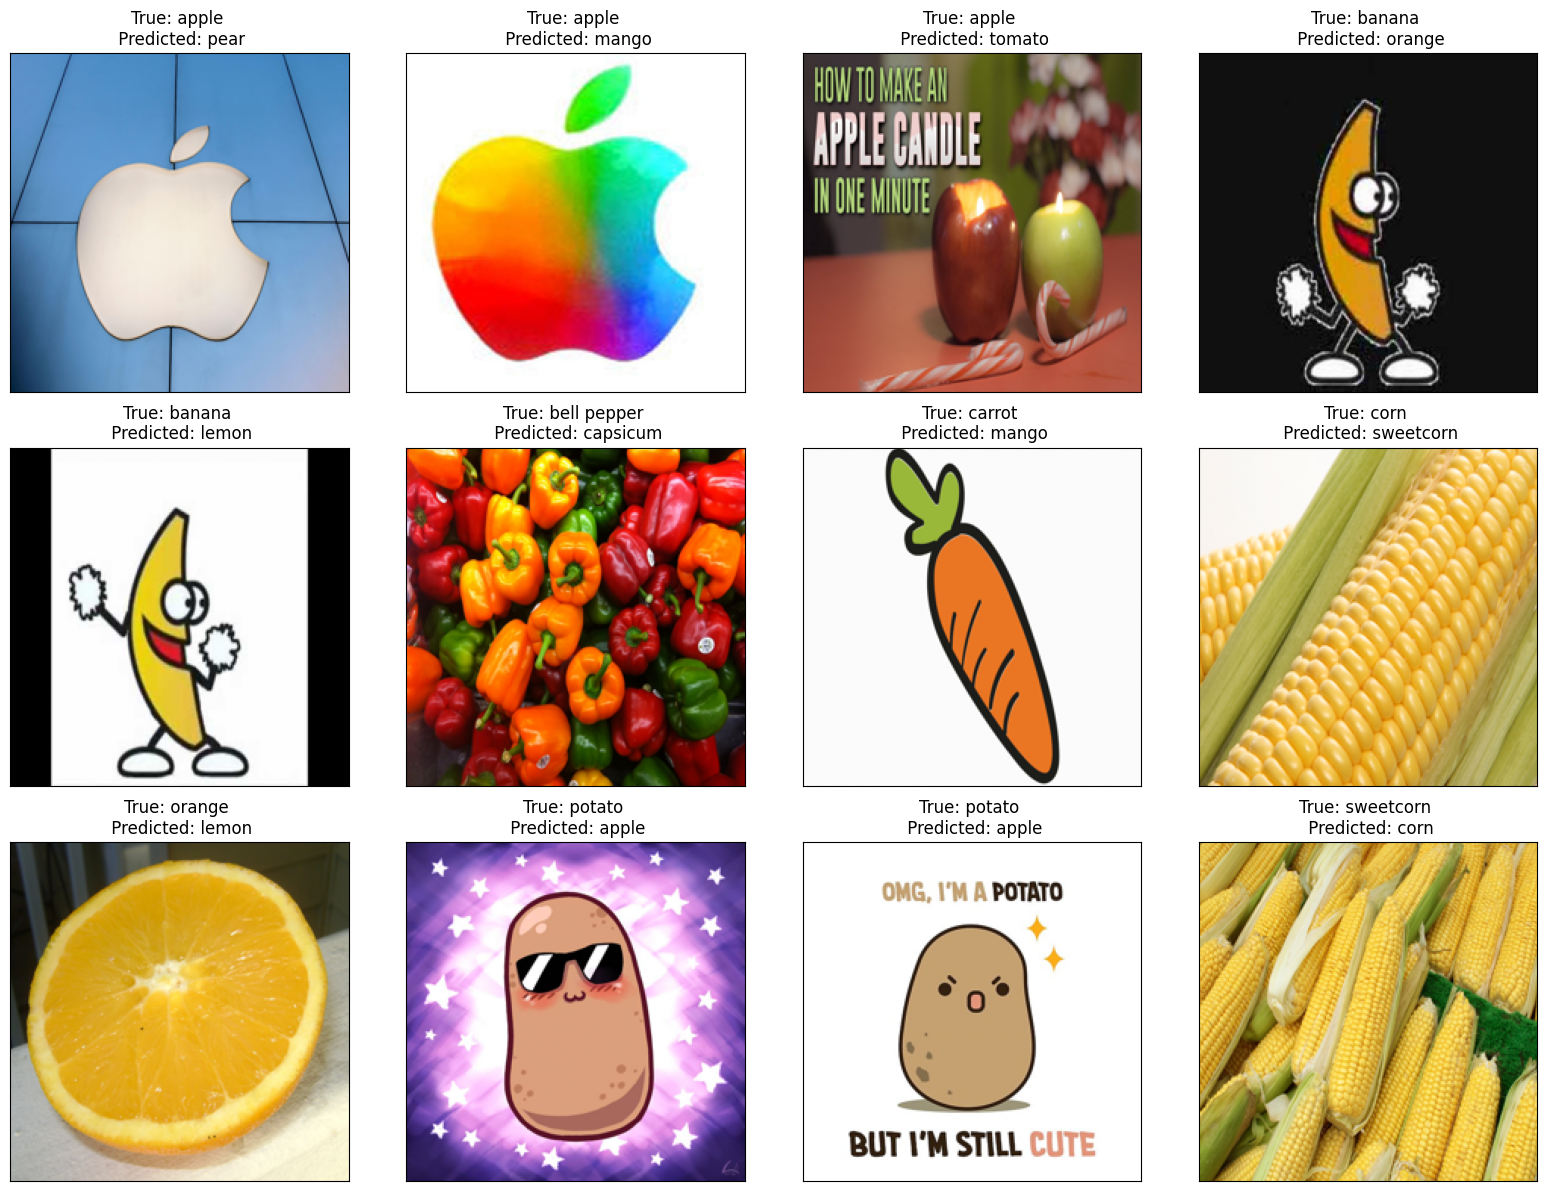

In [150]:
plot_incorrect_predictions(incorrect_predictions, X_test)

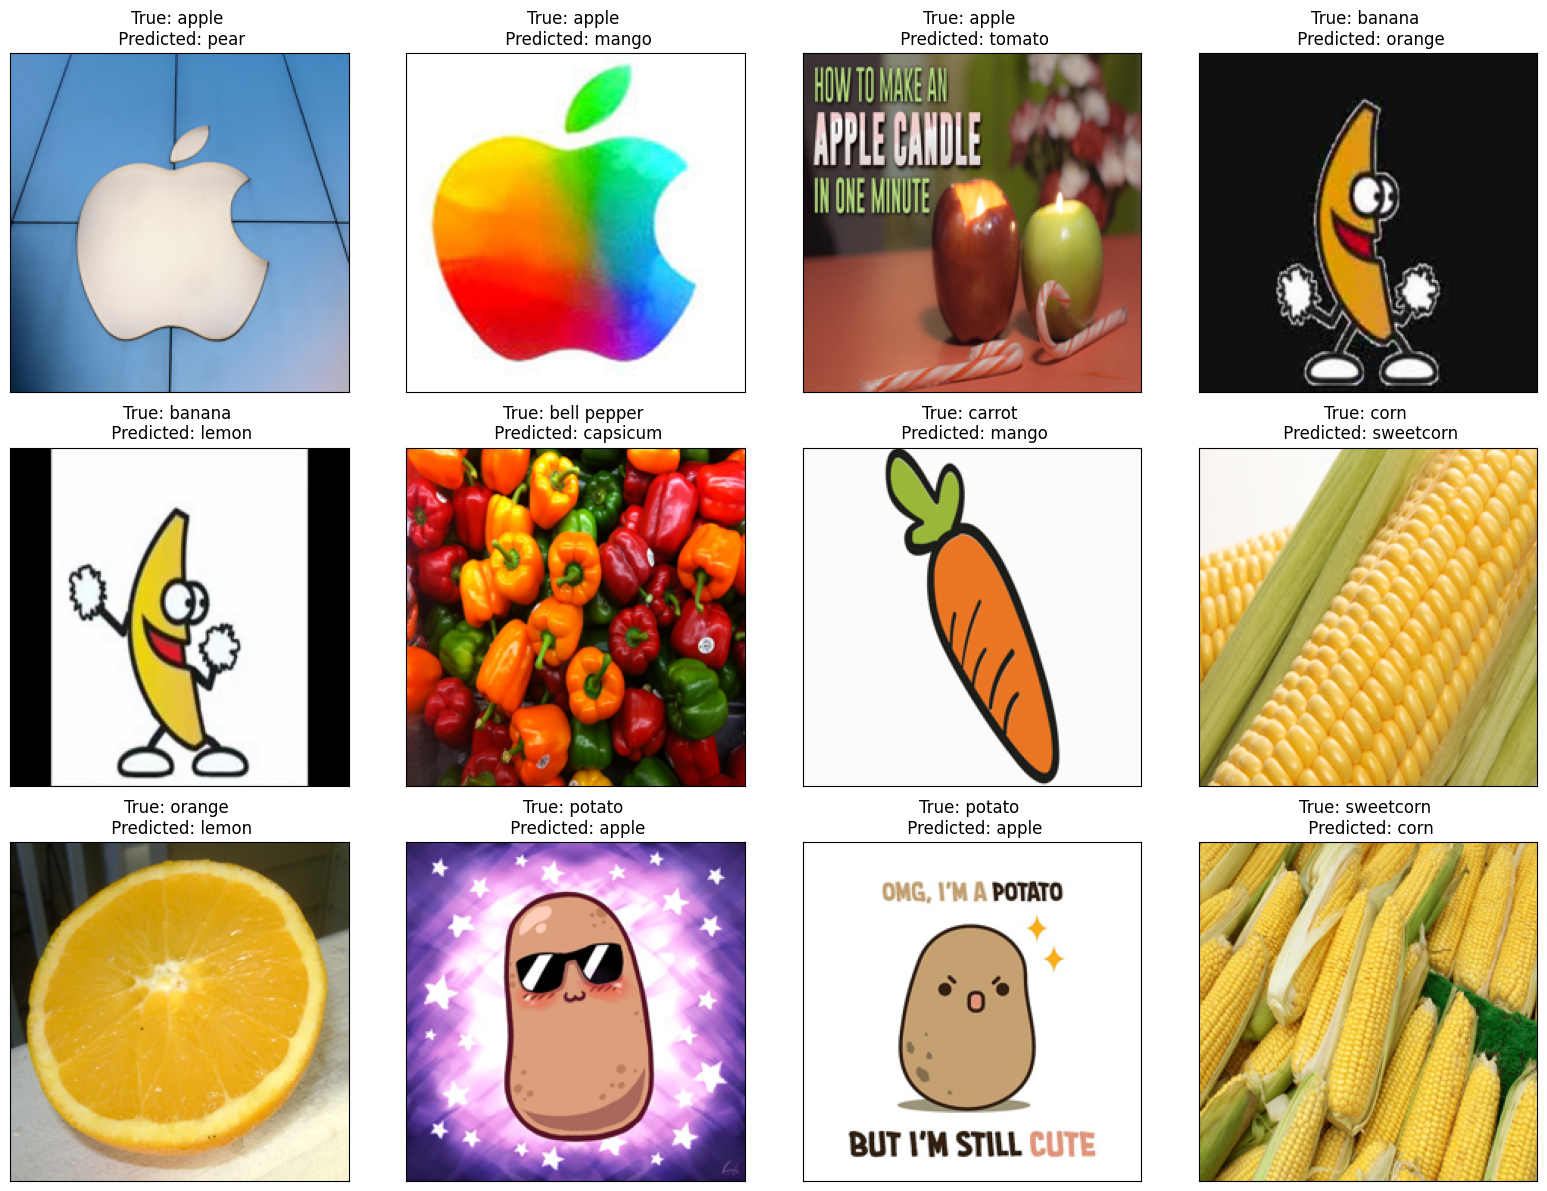

In [145]:
# Calculate grid dimensions
num_images = len(incorrect_predictions)
grid_cols = 4  # Number of columns in the grid
grid_rows = int(np.ceil(num_images / grid_cols))

# Create the grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))  # Adjust figsize as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through images and plot on grid
for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    axes[i].imshow(X_test_not_scaled[index])

    # Set the title of the subplot
    title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
    axes[i].set_title(title)

    # Remove ticks and labels from the subplot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Hide any unused subplots
for j in range(num_images, grid_cols * grid_rows):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()